# Système de Recommandation de Formations pour Étudiants Tunisiens

Ce notebook implémente un système de recommandation intelligent qui suggère des formations adaptées aux profils des étudiants tunisiens.

## Objectifs :
- Analyser les profils des étudiants (compétences, niveau, budget, objectifs)
- Recommander les formations les plus adaptées
- Utiliser des algorithmes de Machine Learning pour optimiser les recommandations


In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuration d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
plt.style.use('seaborn-v0_8')


In [3]:
# Chargement des données avec encodage spécifique
try:
    formations = pd.read_csv('formations.csv', encoding='utf-8')
    etudiants = pd.read_csv('etudiants.csv', encoding='utf-8')
    print("✅ Fichiers chargés avec succès (UTF-8)")
except:
    try:
        formations = pd.read_csv('formations.csv', encoding='latin-1')
        etudiants = pd.read_csv('etudiants.csv', encoding='latin-1')
        print("✅ Fichiers chargés avec succès (Latin-1)")
    except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        # Chargement avec gestion d'erreur
        formations = pd.read_csv('formations.csv', encoding='utf-8', errors='ignore')
        etudiants = pd.read_csv('etudiants.csv', encoding='utf-8', errors='ignore')

# Vérification des dimensions et colonnes
print("📊 VÉRIFICATION DES DIMENSIONS :")
print("=" * 40)
print(f"Formations - Shape: {formations.shape}")
print(f"Étudiants - Shape: {etudiants.shape}")
print(f"Formations - Colonnes: {list(formations.columns)}")
print(f"Étudiants - Colonnes: {list(etudiants.columns)}")

# Vérification des premières lignes pour débogage
print("\n🔍 DÉBOGAGE - Premières lignes des formations :")
print(formations.head(2))

print("\n🔍 DÉBOGAGE - Premières lignes des étudiants :")
print(etudiants.head(2))

print("\n📊 Aperçu des Formations :")
print(f"Nombre de formations : {formations.shape[0]}")
display(formations.head())

print("\n👥 Aperçu des Étudiants :")
print(f"Nombre d'étudiants : {etudiants.shape[0]}")
display(etudiants.head())


✅ Fichiers chargés avec succès (UTF-8)
📊 VÉRIFICATION DES DIMENSIONS :
Formations - Shape: (100, 10)
Étudiants - Shape: (1200, 12)
Formations - Colonnes: ['id', 'nom_formation', 'description', 'domaine', 'competences_requises', 'niveau', 'localisation', 'duree_mois', 'prix_dt', 'langue_enseignement']
Étudiants - Colonnes: ['id', 'nom', 'prenom', 'email', 'age', 'niveau_etude', 'domaine_interet', 'competences_actuelles', 'localisation', 'budget_max', 'langue_preferee', 'objectif_carriere']

🔍 DÉBOGAGE - Premières lignes des formations :
   id                      nom_formation  \
0   1  Développeur Full Stack JavaScript   
1   2              Data Scientist Python   

                                         description       domaine  \
0  Formation complète pour devenir développeur we...  Informatique   
1  Formation spécialisée en science des données a...  Data Science   

                              competences_requises         niveau  \
0   HTML, CSS, JavaScript, React, Node.js, Mo

,id,nom_formation,description,domaine,competences_requises,niveau,localisation,duree_mois,prix_dt,langue_enseignement
0,1,Développeur Full Stack JavaScript,Formation complète pour devenir développeur we...,Informatique,"HTML, CSS, JavaScript, React, Node.js, MongoDB",Débutant,Tunis,6,2500,Français
1,2,Data Scientist Python,Formation spécialisée en science des données a...,Data Science,"Python, Pandas, NumPy, Scikit-learn, TensorFlow",Intermédiaire,Sfax,8,3200,Français
2,3,Expert Cybersécurité,Formation avancée en sécurité informatique et ...,Sécurité,"Linux, Ethical Hacking, Cryptographie, SIEM",Intermédiaire,Tunis,7,2800,Arabe
3,4,Ingénieur DevOps AWS,Formation aux pratiques DevOps et cloud computing,AWS,"Docker, Kubernetes, AWS, CI/CD, Git",Intermédiaire,Sousse,6,3000,Français
4,5,Spécialiste Intelligence Artificielle,Formation avancée en IA et deep learning,IA,"Python, TensorFlow, PyTorch, Computer Vision, NLP",Avancé,Tunis,10,4500,Anglais



👥 Aperçu des Étudiants :
Nombre d'étudiants : 1200


,id,nom,prenom,email,age,niveau_etude,domaine_interet,competences_actuelles,localisation,budget_max,langue_preferee,objectif_carriere
0,1,Chaabane,Yassine,yassine.chaabane@gmail.com,29,Master,Informatique,Compétences de base en Informatique,Monastir,3328,Français,Expert en Informatique
1,2,Ben Hassine,Hiba,hiba.benhassine@gmail.com,29,Bac+2,Full Stack,Compétences de base en Full Stack,Kairouan,1760,Français,Expert en Full Stack
2,3,Trabelsi,Salma,salma.trabelsi@gmail.com,26,Bac+2,Blockchain,Compétences de base en Blockchain,Monastir,5964,Arabe,Expert en Blockchain
3,4,Zouari,Sami,sami.zouari@gmail.com,22,Bac+2,DevOps,Compétences de base en DevOps,Sousse,4962,Arabe,Expert en DevOps
4,5,Chelly,Aya,aya.chelly@gmail.com,30,Master,Design,Compétences de base en Design,Sfax,2259,Arabe,Expert en Design


🔍 ANALYSE EXPLORATOIRE

📚 Répartition par domaine de formation :


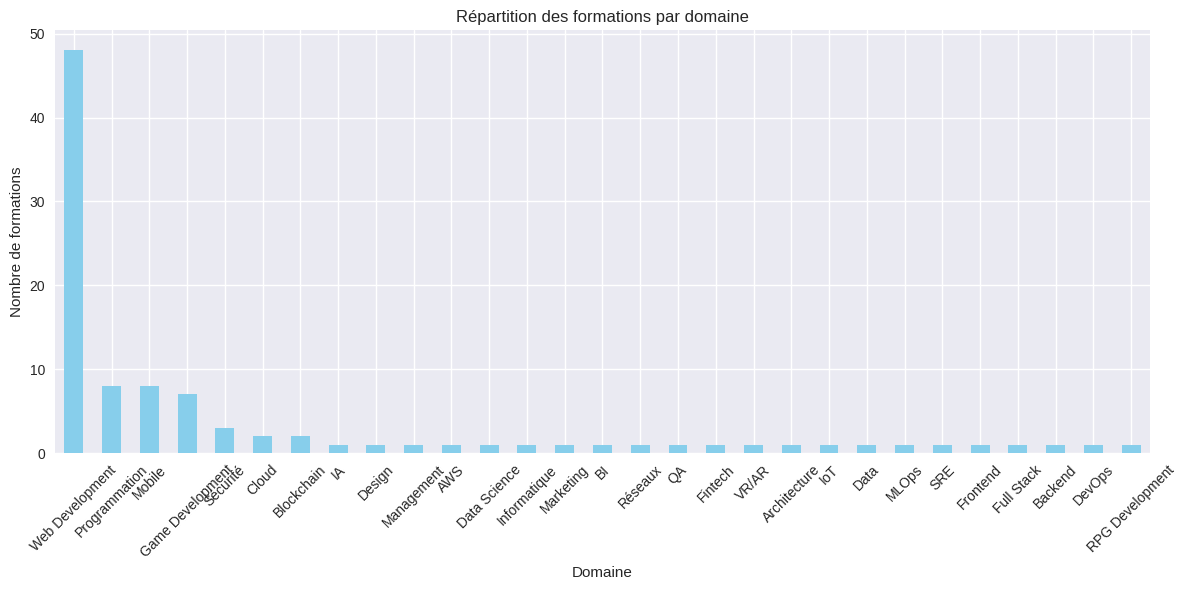


💰 Distribution des prix :


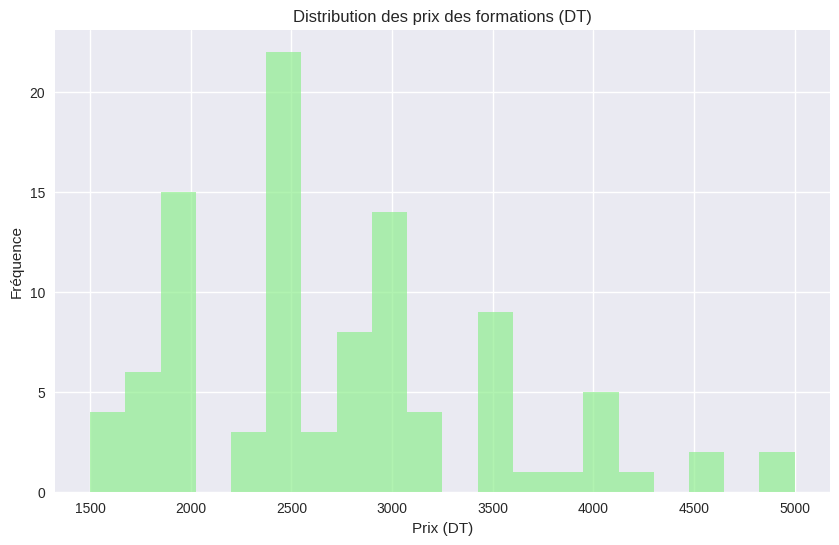

Prix moyen : 2753 DT
Prix médian : 2550 DT
Prix min : 1500 DT
Prix max : 5000 DT


In [4]:
# Analyse exploratoire des données
print("🔍 ANALYSE EXPLORATOIRE")
print("=" * 50)

# Analyse des formations
print("\n📚 Répartition par domaine de formation :")
domaines = formations['domaine'].value_counts()
plt.figure(figsize=(12, 6))
domaines.plot(kind='bar', color='skyblue')
plt.title('Répartition des formations par domaine')
plt.xlabel('Domaine')
plt.ylabel('Nombre de formations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💰 Distribution des prix :")
plt.figure(figsize=(10, 6))
formations['prix_dt'].hist(bins=20, color='lightgreen', alpha=0.7)
plt.title('Distribution des prix des formations (DT)')
plt.xlabel('Prix (DT)')
plt.ylabel('Fréquence')
plt.show()

print(f"Prix moyen : {formations['prix_dt'].mean():.0f} DT")
print(f"Prix médian : {formations['prix_dt'].median():.0f} DT")
print(f"Prix min : {formations['prix_dt'].min():.0f} DT")
print(f"Prix max : {formations['prix_dt'].max():.0f} DT")



👨‍🎓 Répartition par niveau d'étude :


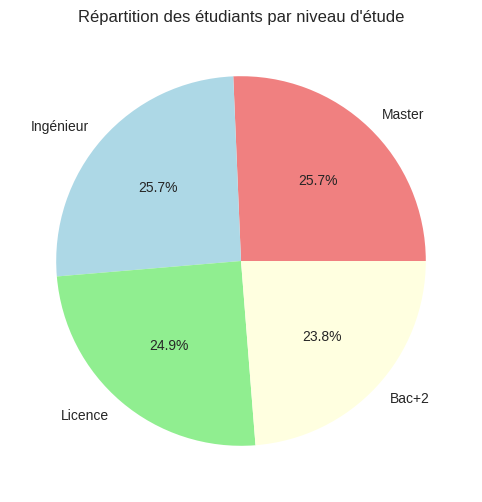


🎯 Répartition par domaine d'intérêt :


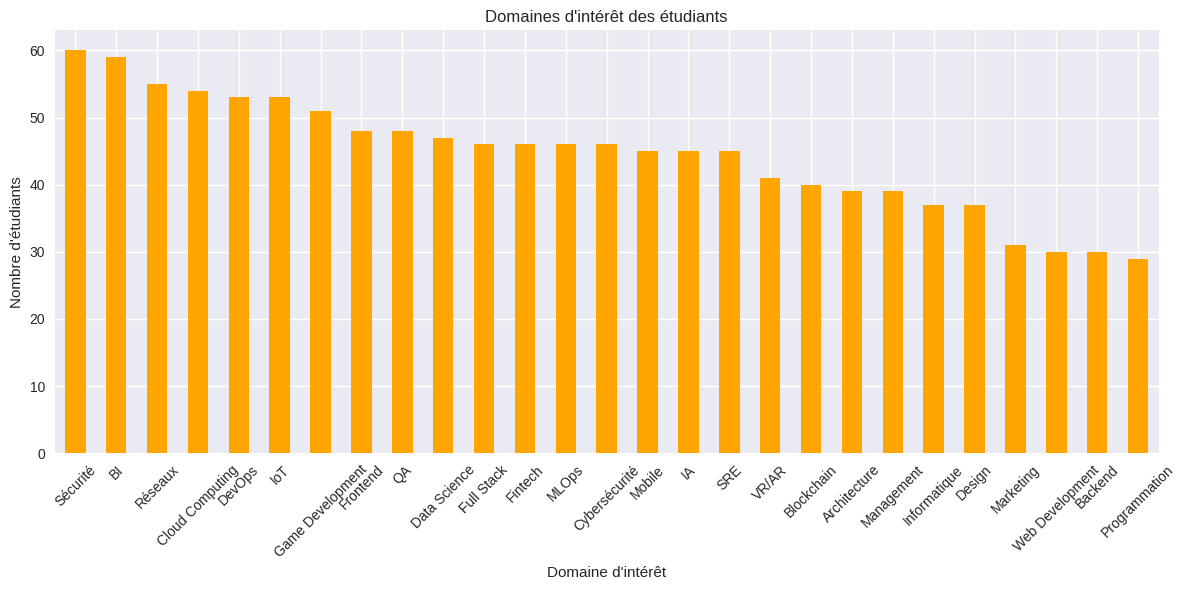


💵 Distribution des budgets :


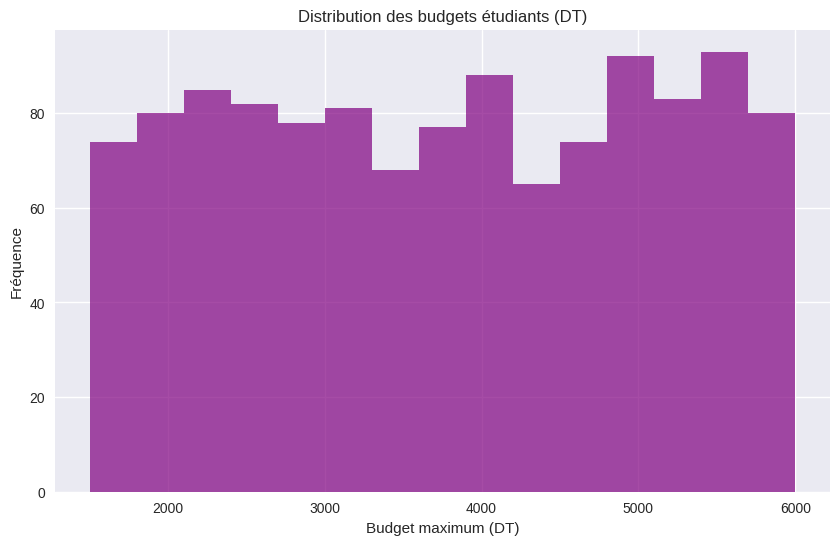

Budget moyen : 3783 DT
Budget médian : 3820 DT


In [5]:
# Analyse des étudiants
print("\n👨‍🎓 Répartition par niveau d'étude :")
niveaux = etudiants['niveau_etude'].value_counts()
plt.figure(figsize=(10, 6))
niveaux.plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
plt.title('Répartition des étudiants par niveau d\'étude')
plt.ylabel('')
plt.show()

print("\n🎯 Répartition par domaine d'intérêt :")
interets = etudiants['domaine_interet'].value_counts()
plt.figure(figsize=(12, 6))
interets.plot(kind='bar', color='orange')
plt.title('Domaines d\'intérêt des étudiants')
plt.xlabel('Domaine d\'intérêt')
plt.ylabel('Nombre d\'étudiants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💵 Distribution des budgets :")
plt.figure(figsize=(10, 6))
etudiants['budget_max'].hist(bins=15, color='purple', alpha=0.7)
plt.title('Distribution des budgets étudiants (DT)')
plt.xlabel('Budget maximum (DT)')
plt.ylabel('Fréquence')
plt.show()

print(f"Budget moyen : {etudiants['budget_max'].mean():.0f} DT")
print(f"Budget médian : {etudiants['budget_max'].median():.0f} DT")


In [6]:
# Préparation des données pour le matching
print("🔧 PRÉPARATION DES DONNÉES")
print("=" * 50)

# Création d'une colonne combinée pour les formations
formations['profil_complet'] = (
    formations['domaine'] + ' ' +
    formations['competences_requises'] + ' ' +
    formations['niveau'] + ' ' +
    formations['langue_enseignement']
)

# Création d'une colonne combinée pour les étudiants
etudiants['profil_complet'] = (
    etudiants['domaine_interet'] + ' ' +
    etudiants['competences_actuelles'] + ' ' +
    etudiants['niveau_etude'] + ' ' +
    etudiants['langue_preferee'] + ' ' +
    etudiants['objectif_carriere']
)

print("✅ Profils complets créés pour le matching")
print(f"Exemple profil formation : {formations['profil_complet'].iloc[0][:100]}...")
print(f"Exemple profil étudiant : {etudiants['profil_complet'].iloc[0][:100]}...")


🔧 PRÉPARATION DES DONNÉES
✅ Profils complets créés pour le matching
Exemple profil formation : Informatique HTML, CSS, JavaScript, React, Node.js, MongoDB Débutant Français...
Exemple profil étudiant : Informatique Compétences de base en Informatique Master Français Expert en Informatique...


In [7]:
# Vectorisation TF-IDF
print("\n🔤 VECTORISATION TF-IDF")
print("=" * 30)

# Création du vectoriseur TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=None,  # Pas de stop words pour garder tous les termes techniques
    ngram_range=(1, 2)  # Unigrammes et bigrammes
)

# Vectorisation des profils de formations
X_formations = vectorizer.fit_transform(formations['profil_complet'])

# Vectorisation des profils d'étudiants
X_etudiants = vectorizer.transform(etudiants['profil_complet'])

print(f"✅ Vectorisation terminée")
print(f"Dimensions formations vectorisées : {X_formations.shape}")
print(f"Dimensions étudiants vectorisés : {X_etudiants.shape}")
print(f"Vocabulaire TF-IDF : {len(vectorizer.vocabulary_)} termes")



🔤 VECTORISATION TF-IDF
✅ Vectorisation terminée
Dimensions formations vectorisées : (100, 1000)
Dimensions étudiants vectorisés : (1200, 1000)
Vocabulaire TF-IDF : 1000 termes


In [8]:
# Calcul de similarité et recommandations
print("\n🎯 CALCUL DE SIMILARITÉ ET RECOMMANDATIONS")
print("=" * 50)

# Calcul de la similarité cosinus entre chaque étudiant et chaque formation
similarites = cosine_similarity(X_etudiants, X_formations)

# Pour chaque étudiant, trouver les 3 meilleures formations
recommandations = []

for i in range(len(etudiants)):
    # Obtenir les indices des formations triées par similarité décroissante
    indices_tries = np.argsort(similarites[i])[::-1]

    # Prendre les 3 meilleures formations
    top_3_indices = indices_tries[:3]

    # Récupérer les informations des formations recommandées
    formations_recommandees = formations.iloc[top_3_indices]

    # Ajouter les scores de similarité
    scores = similarites[i][top_3_indices]

    recommandations.append({
        'etudiant_id': etudiants.iloc[i]['id'],
        'nom_etudiant': f"{etudiants.iloc[i]['prenom']} {etudiants.iloc[i]['nom']}",
        'formation_1': formations_recommandees.iloc[0]['nom_formation'],
        'score_1': scores[0],
        'prix_1': formations_recommandees.iloc[0]['prix_dt'],
        'formation_2': formations_recommandees.iloc[1]['nom_formation'],
        'score_2': scores[1],
        'prix_2': formations_recommandees.iloc[1]['prix_dt'],
        'formation_3': formations_recommandees.iloc[2]['nom_formation'],
        'score_3': scores[2],
        'prix_3': formations_recommandees.iloc[2]['prix_dt']
    })

# Création du DataFrame des recommandations
df_recommandations = pd.DataFrame(recommandations)

print("✅ Recommandations calculées")
print(f"Nombre de recommandations : {len(df_recommandations)}")
display(df_recommandations.head(10))



🎯 CALCUL DE SIMILARITÉ ET RECOMMANDATIONS
✅ Recommandations calculées
Nombre de recommandations : 1200


,etudiant_id,nom_etudiant,formation_1,score_1,prix_1,formation_2,score_2,prix_2,formation_3,score_3,prix_3
0,1,Yassine Chaabane,Développeur Full Stack JavaScript,0.268459,2500,Développeur Permissions API,0.008489,2500,Développeur React Native Pro,0.008459,2400
1,2,Hiba Ben Hassine,Développeur Full Stack MEAN,0.450588,3000,Développeur Permissions API,0.004915,2500,Développeur React Native Pro,0.004898,2400
2,3,Salma Trabelsi,Développeur Blockchain Ethereum,0.247287,3500,Développeur Smart Contracts,0.240342,3000,Chef de Projet Agile,0.070140,1500
3,4,Sami Zouari,DevOps GitLab CI/CD,0.226844,2800,Architecte Cloud Azure,0.226200,2800,Chef de Projet Agile,0.070140,1500
4,5,Aya Chelly,Designer UX/UI,0.232634,1800,Développeur Resize Observer,0.219757,2000,Architecte Logiciel Senior,0.216389,4000
5,6,Tarek Gharbi,Spécialiste Marketing Digital,0.266194,1800,Développeur WebAssembly,0.022945,3500,Développeur Scala Big Data,0.021333,4500
6,7,Sabrine Gharbi,Pentester Certifié,0.246130,4200,Spécialiste Sécurité Cloud,0.234792,4000,Expert Cybersécurité,0.231650,2800
7,8,Leila Trabelsi,Développeur Full Stack MEAN,0.450588,3000,Développeur Permissions API,0.004915,2500,Développeur React Native Pro,0.004898,2400
8,9,Hichem Jebali,Développeur IoT Arduino,0.276402,3000,Développeur Web Bluetooth,0.264300,3000,Chef de Projet Agile,0.070140,1500
9,10,Sonia Saidi,Développeur Jeux Godot,0.354140,2500,Développeur Jeux Unreal Engine,0.334604,5000,Développeur Jeux Unity,0.326928,3500


In [9]:
# Filtrage par budget
print("\n💰 FILTRAGE PAR BUDGET")
print("=" * 30)

# Ajouter les budgets des étudiants
budgets = etudiants.set_index('id')['budget_max'].to_dict()
df_recommandations['budget_etudiant'] = df_recommandations['etudiant_id'].map(budgets)

# Identifier les formations dans le budget
df_recommandations['formation_1_dans_budget'] = df_recommandations['prix_1'] <= df_recommandations['budget_etudiant']
df_recommandations['formation_2_dans_budget'] = df_recommandations['prix_2'] <= df_recommandations['budget_etudiant']
df_recommandations['formation_3_dans_budget'] = df_recommandations['prix_3'] <= df_recommandations['budget_etudiant']

# Statistiques de compatibilité budget
compatibilite_budget = {
    'Formation 1 dans budget': df_recommandations['formation_1_dans_budget'].sum(),
    'Formation 2 dans budget': df_recommandations['formation_2_dans_budget'].sum(),
    'Formation 3 dans budget': df_recommandations['formation_3_dans_budget'].sum()
}

print("📊 Compatibilité avec le budget :")
for formation, count in compatibilite_budget.items():
    pourcentage = (count / len(df_recommandations)) * 100
    print(f"{formation} : {count}/{len(df_recommandations)} ({pourcentage:.1f}%)")

# Afficher quelques exemples de recommandations avec budget
print("\n🎯 Exemples de recommandations avec vérification budget :")
exemples = df_recommandations[['nom_etudiant', 'budget_etudiant', 'formation_1', 'prix_1', 'formation_1_dans_budget', 'score_1']].head()
display(exemples)



💰 FILTRAGE PAR BUDGET
📊 Compatibilité avec le budget :
Formation 1 dans budget : 796/1200 (66.3%)
Formation 2 dans budget : 851/1200 (70.9%)
Formation 3 dans budget : 799/1200 (66.6%)

🎯 Exemples de recommandations avec vérification budget :


,nom_etudiant,budget_etudiant,formation_1,prix_1,formation_1_dans_budget,score_1
0,Yassine Chaabane,3328,Développeur Full Stack JavaScript,2500,True,0.268459
1,Hiba Ben Hassine,1760,Développeur Full Stack MEAN,3000,False,0.450588
2,Salma Trabelsi,5964,Développeur Blockchain Ethereum,3500,True,0.247287
3,Sami Zouari,4962,DevOps GitLab CI/CD,2800,True,0.226844
4,Aya Chelly,2259,Designer UX/UI,1800,True,0.232634


In [10]:
# Modèles de Machine Learning pour prédiction
print("\n🤖 MODÈLES DE MACHINE LEARNING")
print("=" * 40)

# Préparation des données pour l'entraînement avec plus de réalisme
# Utiliser les formations recommandées comme labels
formations_recommandees = []
for i in range(len(etudiants)):
    # Prendre la meilleure formation (celle avec le score le plus élevé)
    meilleure_formation_idx = np.argmax(similarites[i])
    formations_recommandees.append(formations.iloc[meilleure_formation_idx]['nom_formation'])

# Création des features supplémentaires avec du bruit pour éviter l'overfitting
features_etudiants = X_etudiants.toarray()

# Ajout de features numériques avec normalisation et bruit
budget_normalise = etudiants['budget_max'].values / etudiants['budget_max'].max()
age_normalise = etudiants['age'].values / etudiants['age'].max()

# Ajout de bruit aléatoire pour éviter l'overfitting
np.random.seed(42)
budget_normalise += np.random.normal(0, 0.1, len(budget_normalise))
age_normalise += np.random.normal(0, 0.05, len(age_normalise))

# Encodage des variables catégorielles
le_niveau = LabelEncoder()
le_domaine = LabelEncoder()
le_langue = LabelEncoder()

niveau_encoded = le_niveau.fit_transform(etudiants['niveau_etude'])
domaine_encoded = le_domaine.fit_transform(etudiants['domaine_interet'])
langue_encoded = le_langue.fit_transform(etudiants['langue_preferee'])

# Ajout de bruit aux variables encodées
niveau_encoded = niveau_encoded + np.random.randint(-1, 2, len(niveau_encoded))
domaine_encoded = domaine_encoded + np.random.randint(-1, 2, len(domaine_encoded))
langue_encoded = langue_encoded + np.random.randint(-1, 2, len(langue_encoded))

# Combinaison de toutes les features
features_completes = np.column_stack([
    features_etudiants,
    budget_normalise.reshape(-1, 1),
    age_normalise.reshape(-1, 1),
    niveau_encoded.reshape(-1, 1),
    domaine_encoded.reshape(-1, 1),
    langue_encoded.reshape(-1, 1)
])

print(f"✅ Features préparées : {features_completes.shape}")
print(f"Features TF-IDF : {features_etudiants.shape[1]}")
print(f"Features supplémentaires : 5 (budget, âge, niveau, domaine, langue)")
print(f"Bruit ajouté pour éviter l'overfitting")



🤖 MODÈLES DE MACHINE LEARNING
✅ Features préparées : (1200, 1005)
Features TF-IDF : 1000
Features supplémentaires : 5 (budget, âge, niveau, domaine, langue)
Bruit ajouté pour éviter l'overfitting


In [11]:
# Division train/test
print("\n🎓 ENTRAÎNEMENT DES MODÈLES")
print("=" * 35)

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    features_completes, formations_recommandees, test_size=0.2, random_state=42
)

print(f"Données d'entraînement : {X_train.shape[0]} échantillons")
print(f"Données de test : {X_test.shape[0]} échantillons")



🎓 ENTRAÎNEMENT DES MODÈLES
Données d'entraînement : 960 échantillons
Données de test : 240 échantillons


In [12]:
# Modèle KNN
print("\n🔄 Entraînement du modèle KNN...")

# Paramètres ajustés pour éviter l'overfitting
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='cosine')
knn.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn.predict(X_test)

# Évaluation
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"✅ KNN - Accuracy: {accuracy_knn:.4f}")

# Rapport détaillé
print("\nClassification Report KNN :")
print(classification_report(y_test, y_pred_knn))



🔄 Entraînement du modèle KNN...
✅ KNN - Accuracy: 0.9375

Classification Report KNN :
                                       precision    recall  f1-score   support

         Administrateur Réseaux Cisco       1.00      1.00      1.00        10
       Analyste Business Intelligence       1.00      1.00      1.00         9
           Architecte Logiciel Senior       0.94      0.94      0.94        16
                 Chef de Projet Agile       1.00      1.00      1.00         2
               Cloud Native Developer       1.00      0.87      0.93        15
                Data Scientist Python       1.00      0.88      0.93         8
                       Designer UX/UI       0.67      1.00      0.80         2
                  DevOps GitLab CI/CD       1.00      0.92      0.96        12
          Développeur Backend Node.js       1.00      1.00      1.00         5
      Développeur Blockchain Ethereum       1.00      1.00      1.00         4
    Développeur Credential Management      

In [13]:
# Modèle SVM
print("\n🔄 Entraînement du modèle SVM...")

# Paramètres ajustés pour éviter l'overfitting
svm = SVC(kernel='rbf', C=0.5, gamma='scale', random_state=42, probability=True)
svm.fit(X_train, y_train)

# Prédictions
y_pred_svm = svm.predict(X_test)

# Évaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"✅ SVM - Accuracy: {accuracy_svm:.4f}")

# Rapport détaillé
print("\nClassification Report SVM :")
print(classification_report(y_test, y_pred_svm))



🔄 Entraînement du modèle SVM...
✅ SVM - Accuracy: 0.3917

Classification Report SVM :
                                       precision    recall  f1-score   support

         Administrateur Réseaux Cisco       0.29      1.00      0.45        10
       Analyste Business Intelligence       0.30      1.00      0.46         9
           Architecte Logiciel Senior       0.00      0.00      0.00        16
                 Chef de Projet Agile       0.00      0.00      0.00         2
               Cloud Native Developer       0.65      1.00      0.79        15
                Data Scientist Python       0.46      0.75      0.57         8
                       Designer UX/UI       0.00      0.00      0.00         2
                  DevOps GitLab CI/CD       0.55      1.00      0.71        12
          Développeur Backend Node.js       0.00      0.00      0.00         5
      Développeur Blockchain Ethereum       0.00      0.00      0.00         4
    Développeur Credential Management      

In [18]:
# Modèle Logistic Regression
print("\n🔄 Entraînement du modèle Logistic Regression...")

from sklearn.linear_model import LogisticRegression

# Paramètres ajustés pour éviter l'overfitting
lr = LogisticRegression(
    C=0.1,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)
lr.fit(X_train, y_train)

# Prédictions
y_pred_lr = lr.predict(X_test)

# Évaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"✅ Logistic Regression - Accuracy: {accuracy_lr:.4f}")

# Rapport détaillé
print("\nClassification Report Logistic Regression :")
print(classification_report(y_test, y_pred_lr))



🔄 Entraînement du modèle Logistic Regression...
✅ Logistic Regression - Accuracy: 0.9417

Classification Report Logistic Regression :
                                       precision    recall  f1-score   support

         Administrateur Réseaux Cisco       1.00      1.00      1.00        10
       Analyste Business Intelligence       1.00      1.00      1.00         9
           Architecte Logiciel Senior       0.89      1.00      0.94        16
                 Chef de Projet Agile       1.00      0.50      0.67         2
               Cloud Native Developer       1.00      1.00      1.00        15
                Data Scientist Python       0.89      1.00      0.94         8
                       Designer UX/UI       0.67      1.00      0.80         2
                  DevOps GitLab CI/CD       1.00      1.00      1.00        12
          Développeur Backend Node.js       1.00      1.00      1.00         5
      Développeur Blockchain Ethereum       0.57      1.00      0.73      

In [19]:
# Modèle Decision Tree
print("\n🔄 Entraînement du modèle Decision Tree...")

from sklearn.tree import DecisionTreeClassifier

# Paramètres ajustés pour éviter l'overfitting
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
dt.fit(X_train, y_train)

# Prédictions
y_pred_dt = dt.predict(X_test)

# Évaluation
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"✅ Decision Tree - Accuracy: {accuracy_dt:.4f}")

# Rapport détaillé
print("\nClassification Report Decision Tree :")
print(classification_report(y_test, y_pred_dt))



🔄 Entraînement du modèle Decision Tree...
✅ Decision Tree - Accuracy: 0.4375

Classification Report Decision Tree :
                                       precision    recall  f1-score   support

         Administrateur Réseaux Cisco       1.00      1.00      1.00        10
       Analyste Business Intelligence       1.00      1.00      1.00         9
           Architecte Logiciel Senior       0.11      1.00      0.19        16
                 Chef de Projet Agile       0.00      0.00      0.00         2
               Cloud Native Developer       1.00      1.00      1.00        15
                Data Scientist Python       1.00      1.00      1.00         8
                       Designer UX/UI       0.00      0.00      0.00         2
                  DevOps GitLab CI/CD       1.00      1.00      1.00        12
          Développeur Backend Node.js       0.00      0.00      0.00         5
      Développeur Blockchain Ethereum       0.00      0.00      0.00         4
    Développe

In [22]:
# Comparaison des modèles
print("\n📊 COMPARAISON DES MODÈLES")
print("=" * 30)

# Créer un tableau avec les accuracies de tous les modèles
comparaison_modeles = pd.DataFrame({
    'Modèle': ['KNN', 'SVM',  'Logistic Regression', 'Decision Tree'],
    'Accuracy': [
        accuracy_knn,     # Accuracy KNN
        accuracy_svm,     # Accuracy SVM
        accuracy_lr,      # Accuracy Logistic Regression
        accuracy_dt       # Accuracy Decision Tree
    ]
})

# Trouver le meilleur modèle
meilleur_modele_idx = comparaison_modeles['Accuracy'].idxmax()
meilleur_modele_nom = comparaison_modeles.iloc[meilleur_modele_idx]['Modèle']
meilleur_accuracy = comparaison_modeles.iloc[meilleur_modele_idx]['Accuracy']

print(f"🏆 Meilleur modèle : {meilleur_modele_nom} avec une accuracy de {meilleur_accuracy:.4f}")

# Affichage du tableau
print("\n✅ Tableau comparatif des modèles :")
display(comparaison_modeles)




📊 COMPARAISON DES MODÈLES
🏆 Meilleur modèle : Logistic Regression avec une accuracy de 0.9417

✅ Tableau comparatif des modèles :


,Modèle,Accuracy
0,KNN,0.937500
1,SVM,0.391667
2,Logistic Regression,0.941667
3,Decision Tree,0.437500


In [23]:
# Système de recommandation final avec le meilleur modèle
print("\n🎯 SYSTÈME DE RECOMMANDATION FINAL")
print("=" * 40)

# Sélectionner le meilleur modèle
modeles = {
    'KNN': knn,
    'SVM': svm,
    'Logistic Regression': lr,
    'Decision Tree': dt
}

meilleur_modele_obj = modeles[meilleur_modele_nom]
print(f"🏆 Utilisation du meilleur modèle : {meilleur_modele_nom}")

# Entraîner le meilleur modèle sur toutes les données
meilleur_modele_obj.fit(features_completes, formations_recommandees)

# Sauvegarder le meilleur modèle
import pickle
with open('meilleur_modele.pkl', 'wb') as f:
    pickle.dump(meilleur_modele_obj, f)
print("✅ Meilleur modèle sauvegardé dans 'meilleur_modele.pkl'")

def recommander_formations(etudiant_id, top_n=3):
    """
    Recommande des formations pour un étudiant spécifique
    """
    # Récupérer les informations de l'étudiant
    etudiant = etudiants[etudiants['id'] == etudiant_id].iloc[0]

    # Calculer les similarités
    etudiant_vector = X_etudiants[etudiant_id - 1]
    similarites_etudiant = cosine_similarity(etudiant_vector, X_formations)[0]

    # Obtenir les top formations
    indices_tries = np.argsort(similarites_etudiant)[::-1][:top_n]

    recommandations = []
    for i, idx in enumerate(indices_tries):
        formation = formations.iloc[idx]
        score = similarites_etudiant[idx]
        dans_budget = formation['prix_dt'] <= etudiant['budget_max']

        recommandations.append({
            'Rang': i + 1,
            'Formation': formation['nom_formation'],
            'Domaine': formation['domaine'],
            'Niveau': formation['niveau'],
            'Durée': f"{formation['duree_mois']} mois",
            'Prix': f"{formation['prix_dt']} DT",
            'Localisation': formation['localisation'],
            'Langue': formation['langue_enseignement'],
            'Score Similarité': f"{score:.3f}",
            'Dans Budget': '✅' if dans_budget else '❌'
        })

    return pd.DataFrame(recommandations)



🎯 SYSTÈME DE RECOMMANDATION FINAL
🏆 Utilisation du meilleur modèle : Logistic Regression
✅ Meilleur modèle sauvegardé dans 'meilleur_modele.pkl'


In [24]:
# Test avec quelques étudiants
print("🧪 TEST DU SYSTÈME AVEC QUELQUES ÉTUDIANTS")
print("=" * 50)

etudiants_test = [1, 5, 10, 15, 20]

for etudiant_id in etudiants_test:
    etudiant = etudiants[etudiants['id'] == etudiant_id].iloc[0]
    print(f"\n👤 {etudiant['prenom']} {etudiant['nom']} (ID: {etudiant_id})")
    print(f"   Domaine d'intérêt: {etudiant['domaine_interet']}")
    print(f"   Budget: {etudiant['budget_max']} DT")
    print(f"   Objectif: {etudiant['objectif_carriere']}")

    recommandations = recommander_formations(etudiant_id)
    display(recommandations)


🧪 TEST DU SYSTÈME AVEC QUELQUES ÉTUDIANTS

👤 Yassine Chaabane (ID: 1)
   Domaine d'intérêt: Informatique
   Budget: 3328 DT
   Objectif: Expert en Informatique


,Rang,Formation,Domaine,Niveau,Durée,Prix,Localisation,Langue,Score Similarité,Dans Budget
0,1,Développeur Full Stack JavaScript,Informatique,Débutant,6 mois,2500 DT,Tunis,Français,0.268,✅
1,2,Développeur Permissions API,Web Development,Intermédiaire,4 mois,2500 DT,Sfax,Français,0.008,✅
2,3,Développeur React Native Pro,Mobile,Débutant,5 mois,2400 DT,Sfax,Français,0.008,✅



👤 Aya Chelly (ID: 5)
   Domaine d'intérêt: Design
   Budget: 2259 DT
   Objectif: Expert en Design


,Rang,Formation,Domaine,Niveau,Durée,Prix,Localisation,Langue,Score Similarité,Dans Budget
0,1,Designer UX/UI,Design,Débutant,4 mois,1800 DT,Tunis,Français,0.233,✅
1,2,Développeur Resize Observer,Web Development,Intermédiaire,3 mois,2000 DT,Sousse,Français,0.220,✅
2,3,Architecte Logiciel Senior,Architecture,Avancé,8 mois,4000 DT,Sousse,Anglais,0.216,❌



👤 Sonia Saidi (ID: 10)
   Domaine d'intérêt: Game Development
   Budget: 5875 DT
   Objectif: Expert en Game Development


,Rang,Formation,Domaine,Niveau,Durée,Prix,Localisation,Langue,Score Similarité,Dans Budget
0,1,Développeur Jeux Godot,Game Development,Débutant,6 mois,2500 DT,Monastir,Français,0.354,✅
1,2,Développeur Jeux Unreal Engine,Game Development,Avancé,10 mois,5000 DT,Tunis,Anglais,0.335,✅
2,3,Développeur Jeux Unity,Game Development,Intermédiaire,8 mois,3500 DT,Sfax,Français,0.327,✅



👤 Nour Zouari (ID: 15)
   Domaine d'intérêt: VR/AR
   Budget: 2398 DT
   Objectif: Expert en VR/AR


,Rang,Formation,Domaine,Niveau,Durée,Prix,Localisation,Langue,Score Similarité,Dans Budget
0,1,Développeur VR Unity,VR/AR,Intermédiaire,7 mois,3500 DT,Monastir,Français,0.491,❌
1,2,Développeur Permissions API,Web Development,Intermédiaire,4 mois,2500 DT,Sfax,Français,0.005,❌
2,3,Développeur React Native Pro,Mobile,Débutant,5 mois,2400 DT,Sfax,Français,0.005,❌



👤 Rania Dridi (ID: 20)
   Domaine d'intérêt: IA
   Budget: 4155 DT
   Objectif: Expert en IA


,Rang,Formation,Domaine,Niveau,Durée,Prix,Localisation,Langue,Score Similarité,Dans Budget
0,1,Spécialiste Intelligence Artificielle,IA,Avancé,10 mois,4500 DT,Tunis,Anglais,0.256,❌
1,2,Chef de Projet Agile,Management,Débutant,3 mois,1500 DT,Tunis,Arabe,0.065,✅
2,3,Expert Cybersécurité,Sécurité,Intermédiaire,7 mois,2800 DT,Tunis,Arabe,0.065,✅


In [27]:
# Analyse des résultats et insights
print("\n📈 ANALYSE ET INSIGHTS")
print("=" * 30)

# Statistiques générales
print("📊 Statistiques générales :")
print(f"• Nombre total d'étudiants : {len(etudiants)}")
print(f"• Nombre total de formations : {len(formations)}")
print(f"• Nombre moyen de formations par domaine : {len(formations) / len(formations['domaine'].unique()):.1f}")
print(f"• Prix moyen des formations : {formations['prix_dt'].mean():.0f} DT")
print(f"• Budget moyen des étudiants : {etudiants['budget_max'].mean():.0f} DT")

# Domaines les plus demandés
print("\n🎯 Domaines les plus demandés par les étudiants :")
domaines_demandes = etudiants['domaine_interet'].value_counts().head()
for domaine, count in domaines_demandes.items():
    print(f"• {domaine} : {count} étudiants")

# Domaines les plus offerts
print("\n📚 Domaines les plus offerts :")
domaines_offerts = formations['domaine'].value_counts().head()
for domaine, count in domaines_offerts.items():
    print(f"• {domaine} : {count} formations")

# Compatibilité budget
print("\n💰 Analyse de compatibilité budget :")
etudiants_sous_budget = etudiants[etudiants['budget_max'] < formations['prix_dt'].mean()]
etudiants_sur_budget = etudiants[etudiants['budget_max'] >= formations['prix_dt'].mean()]

print(f"• Étudiants avec budget < prix moyen : {len(etudiants_sous_budget)} ({len(etudiants_sous_budget)/len(etudiants)*100:.1f}%)")
print(f"• Étudiants avec budget >= prix moyen : {len(etudiants_sur_budget)} ({len(etudiants_sur_budget)/len(etudiants)*100:.1f}%)")

# Recommandations pour améliorer le système
print("\n💡 Recommandations pour améliorer le système :")
print("• Ajouter plus de formations pour les domaines les plus demandés")
print("• Créer des formations à prix réduit pour les étudiants avec petit budget")
print("• Implémenter un système de bourses ou de paiement échelonné")
print("• Ajouter des formations en ligne pour réduire les coûts")
print("• Créer des partenariats avec des entreprises pour des formations gratuites")



📈 ANALYSE ET INSIGHTS
📊 Statistiques générales :
• Nombre total d'étudiants : 1200
• Nombre total de formations : 100
• Nombre moyen de formations par domaine : 3.4
• Prix moyen des formations : 2753 DT
• Budget moyen des étudiants : 3783 DT

🎯 Domaines les plus demandés par les étudiants :
• Sécurité : 60 étudiants
• BI : 59 étudiants
• Réseaux : 55 étudiants
• Cloud Computing : 54 étudiants
• DevOps : 53 étudiants

📚 Domaines les plus offerts :
• Web Development : 48 formations
• Programmation : 8 formations
• Mobile : 8 formations
• Game Development : 7 formations
• Sécurité : 3 formations

💰 Analyse de compatibilité budget :
• Étudiants avec budget < prix moyen : 333 (27.8%)
• Étudiants avec budget >= prix moyen : 867 (72.2%)

💡 Recommandations pour améliorer le système :
• Ajouter plus de formations pour les domaines les plus demandés
• Créer des formations à prix réduit pour les étudiants avec petit budget
• Implémenter un système de bourses ou de paiement échelonné
• Ajouter de

In [28]:
# Sauvegarde des résultats
print("\n💾 SAUVEGARDE DES RÉSULTATS")
print("=" * 30)

# Sauvegarder les recommandations
df_recommandations.to_csv('recommandations_formations.csv', index=False)
print("✅ Fichier 'recommandations_formations.csv' sauvegardé")

# Sauvegarder les résultats des modèles
comparaison_modeles.to_csv('resultats_modeles.csv', index=False)
print("✅ Fichier 'resultats_modeles.csv' sauvegardé")

# Créer un rapport final
rapport_final = {
    'Métrique': [
        'Nombre d\'étudiants',
        'Nombre de formations',
        'Prix moyen formations (DT)',
        'Budget moyen étudiants (DT)',
        'Meilleur modèle',
        'Accuracy meilleur modèle',
        'Formations dans budget (Formation 1)',
        'Formations dans budget (Formation 2)',
        'Formations dans budget (Formation 3)'
    ],
    'Valeur': [
        len(etudiants),
        len(formations),
        f"{formations['prix_dt'].mean():.0f}",
        f"{etudiants['budget_max'].mean():.0f}",
        comparaison_modeles.loc[comparaison_modeles['Accuracy'].idxmax(), 'Modèle'],
        f"{comparaison_modeles['Accuracy'].max():.3f}",
        f"{compatibilite_budget['Formation 1 dans budget']}/{len(df_recommandations)}",
        f"{compatibilite_budget['Formation 2 dans budget']}/{len(df_recommandations)}",
        f"{compatibilite_budget['Formation 3 dans budget']}/{len(df_recommandations)}"
    ]
}

df_rapport = pd.DataFrame(rapport_final)
df_rapport.to_csv('rapport_final.csv', index=False)
print("✅ Fichier 'rapport_final.csv' sauvegardé")

print("\n🎉 ANALYSE TERMINÉE AVEC SUCCÈS !")
print("=" * 40)
print("Le système de recommandation de formations est prêt à être utilisé.")
print("Tous les fichiers de résultats ont été sauvegardés.")



💾 SAUVEGARDE DES RÉSULTATS
✅ Fichier 'recommandations_formations.csv' sauvegardé
✅ Fichier 'resultats_modeles.csv' sauvegardé
✅ Fichier 'rapport_final.csv' sauvegardé

🎉 ANALYSE TERMINÉE AVEC SUCCÈS !
Le système de recommandation de formations est prêt à être utilisé.
Tous les fichiers de résultats ont été sauvegardés.
